#### Bibliotecas

In [497]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

#### Base de dados

In [498]:
df = pd.read_csv("../dados/nova_plataforma.csv")

In [499]:
df.shape

(7, 28)

In [500]:
df.head()

,platform,water_depth (m),weight (t),installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure (m),distance_to_coast (km),risk_to_other_users-complete,risk_to_other_users-partial,risk_to_personnel-complete,risk_to_personnel-partial,energy_consumption-complete (GJ),energy_consumption-partial (GJ),emissions-complete (t),emissions-partial (t),impacts_of_option-complete,impacts_of_option-partial,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-complete,total_removal_cost-partial,recommended (1 partial; 2 complete)
0,1,99,22000,36,1,8,8,114.0,269,1,0.000000e+00,0.290,0.12,1110100,817000,87000,58500,0.00,1.0,0.00,1.00,0.79,0.78,0.5,0.5,1.00,0.56,1.0
1,2,112,20364,41,1,8,9,123.0,259,1,0.000000e+00,0.320,0.16,1180500,895500,92000,64000,0.00,1.0,0.00,1.00,0.79,0.78,0.5,0.5,1.00,0.56,1.0
2,20,141,15561,46,2,8,26,147.0,120,0,2.300000e-05,0.025,0.01,297654,530148,24277,31064,0.66,1.0,0.25,1.00,1.00,0.94,1.0,1.0,0.53,1.00,1.0
3,25,156,27647,44,2,8,32,166.0,240,0,1.500000e-05,0.040,0.02,487750,570818,40416,45266,1.00,1.0,0.50,1.00,1.00,0.66,1.0,1.0,1.00,0.57,1.0
4,26,103,18584,33,1,8,20,122.5,230,0,7.800000e-08,0.090,0.06,733082,511765,59588,41170,0.53,1.0,0.39,0.15,0.00,0.00,0.0,0.0,1.00,0.73,1.0


In [501]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 28 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   platform                                          7 non-null      int64  
 1   water_depth (m)                                   7 non-null      int64  
 2   weight (t)                                        7 non-null      int64  
 3   installation_date                                 7 non-null      int64  
 4   type_of_production (1 oil and gas; 2 oil; 3 gas)  7 non-null      int64  
 5   number_of_legs                                    7 non-null      int64  
 6   number_of_piles                                   7 non-null      int64  
 7   height_of_jacket_or_sub-structure (m)             7 non-null      float64
 8   distance_to_coast (km)                            7 non-null      int64  
 9   risk_to_other_users-compl

In [502]:
platform_remove = ['platform', 'recommended (1 partial; 2 complete)']

In [503]:
df.drop(platform_remove, axis=1, inplace=True)

In [504]:
df.shape

(7, 26)

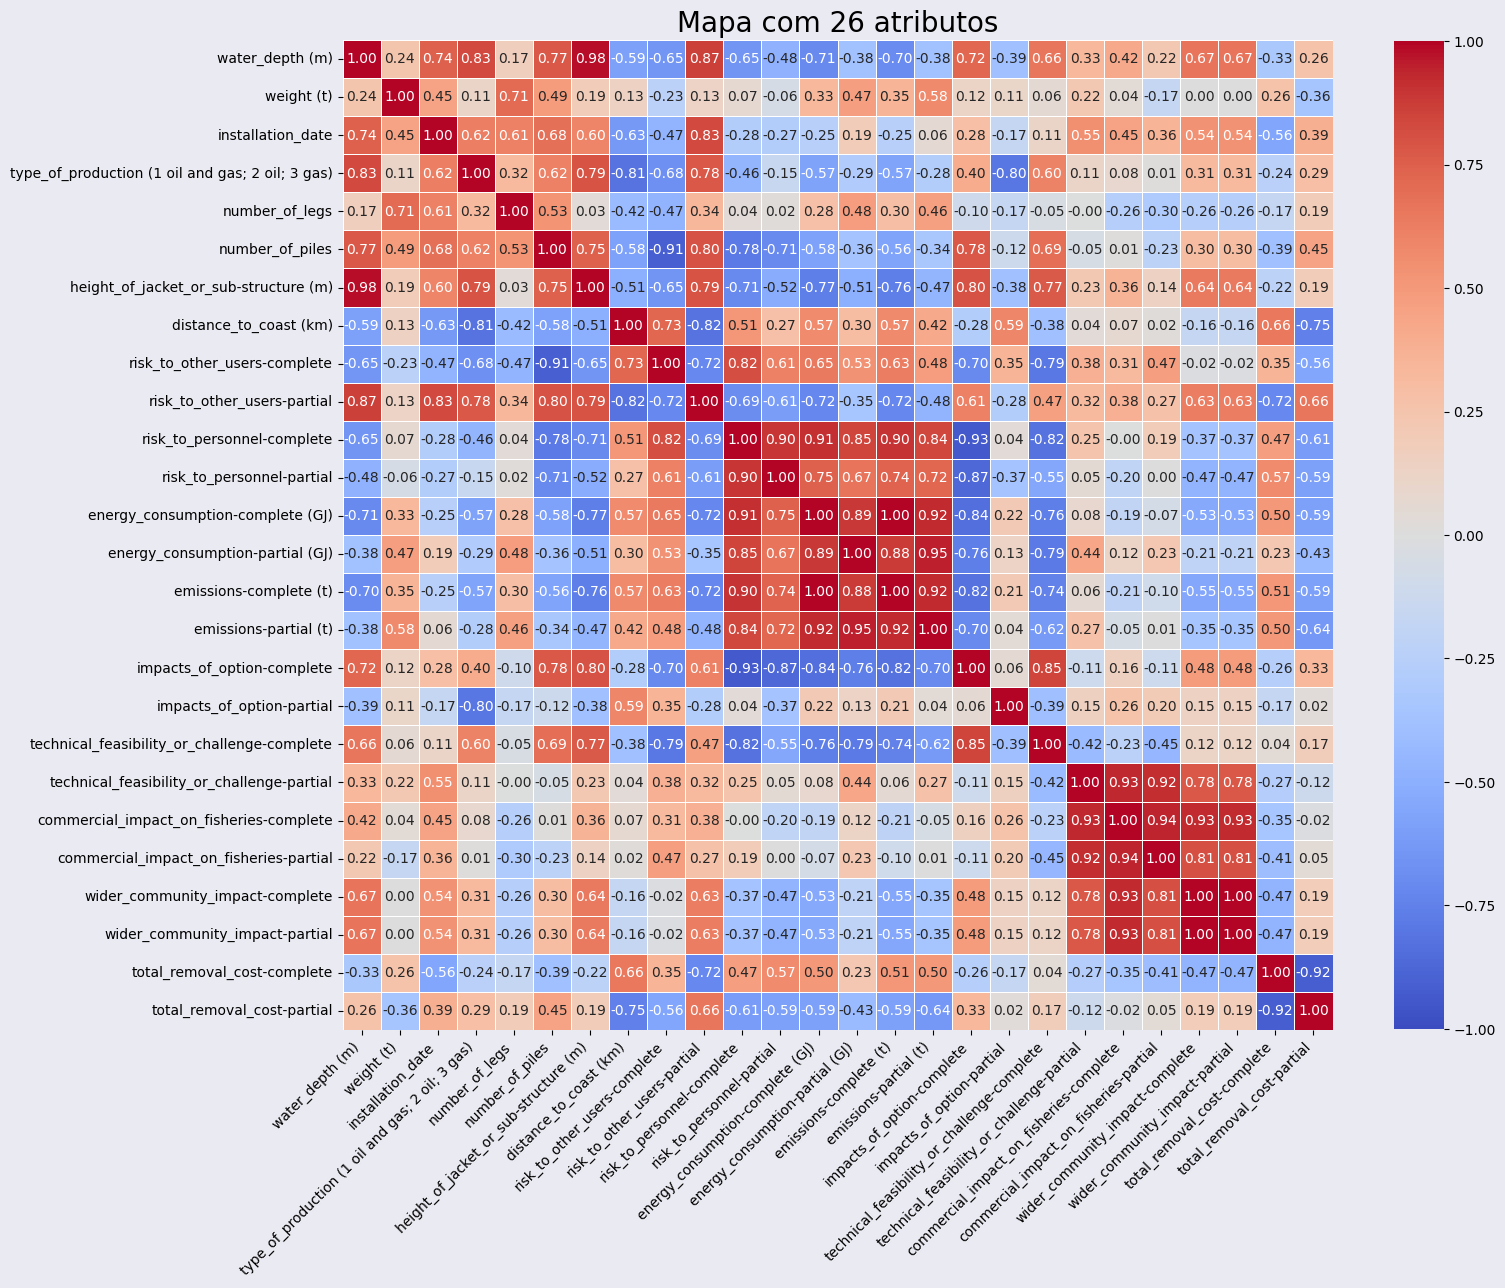

In [505]:
matriz_correlacao = df.corr()

plt.figure(figsize=(16, 16), facecolor='#eaeaf2')

ax = sns.heatmap(data=matriz_correlacao,
                xticklabels=df.columns,
                yticklabels=df.columns,
                annot=True, 
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                fmt='.2f',
                linewidths=0.7,
                cbar=True,
                cbar_kws={"shrink": 0.685}
)

# Ajustando as labels na linha x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Mapa com 26 atributos', fontsize=20)

plt.tight_layout()

plt.show()

In [506]:
df['impacts_of_option-partial']

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    0.4
6    1.0
Name: impacts_of_option-partial, dtype: float64

In [507]:
df

,water_depth (m),weight (t),installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure (m),distance_to_coast (km),risk_to_other_users-complete,risk_to_other_users-partial,risk_to_personnel-complete,risk_to_personnel-partial,energy_consumption-complete (GJ),energy_consumption-partial (GJ),emissions-complete (t),emissions-partial (t),impacts_of_option-complete,impacts_of_option-partial,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-complete,total_removal_cost-partial
0,99,22000,36,1,8,8,114.0,269,1,0.000000e+00,0.290,0.12,1110100,817000,87000,58500,0.00,1.0,0.00,1.00,0.79,0.78,0.50,0.50,1.00,0.56
1,112,20364,41,1,8,9,123.0,259,1,0.000000e+00,0.320,0.16,1180500,895500,92000,64000,0.00,1.0,0.00,1.00,0.79,0.78,0.50,0.50,1.00,0.56
2,141,15561,46,2,8,26,147.0,120,0,2.300000e-05,0.025,0.01,297654,530148,24277,31064,0.66,1.0,0.25,1.00,1.00,0.94,1.00,1.00,0.53,1.00
3,156,27647,44,2,8,32,166.0,240,0,1.500000e-05,0.040,0.02,487750,570818,40416,45266,1.00,1.0,0.50,1.00,1.00,0.66,1.00,1.00,1.00,0.57
4,103,18584,33,1,8,20,122.5,230,0,7.800000e-08,0.090,0.06,733082,511765,59588,41170,0.53,1.0,0.39,0.15,0.00,0.00,0.00,0.00,1.00,0.73
5,144,17500,41,3,8,20,154.0,130,0,1.335933e-05,0.140,0.13,520000,568000,42000,44000,0.40,0.4,0.45,0.70,0.50,0.50,0.50,0.50,1.00,0.66
6,116,10054,31,1,4,5,136.0,282,1,0.000000e+00,0.140,0.08,469823,433179,37162,32191,0.53,1.0,0.29,0.81,0.93,0.86,0.83,0.83,1.00,0.60


In [508]:
remove_impacts_partial = ['impacts_of_option-partial']

In [509]:
df.drop(remove_impacts_partial, axis=1, inplace=True)

In [510]:
df.shape

(7, 25)

#### Aplicação da GAN

##### Gerador

In [511]:
class Gerador(nn.Module):
    """
    O gerador recebe um vetor de entrada (contendo números aleatórios) e mapeia para o espaço de saída desejado, 
    produzindo um registro sintético.

    Parâmetros:
        - tamanho_entrada (int): O tamanho do vetor de entrada, que representa a dimensão do espaço latente.
        - tamanho_saida (int): O tamanho do vetor de saída, que representa a dimensão do registro sintético.
        - min_values (torch.Tensor): O tensor contendo os valores mínimos para cada coluna do dataframe original.
        - max_values (torch.Tensor): O tensor contendo os valores máximos para cada coluna do dataframe original.
    """
    
    def __init__(self, tamanho_entrada, tamanho_saida, min_values, max_values):
        super(Gerador, self).__init__()
        
        # Definição da arquitetura do modelo
        self.modelo = nn.Sequential(
            nn.Linear(tamanho_entrada, 128), # Primeira camada de entrada (linear)
            nn.ReLU(), # Capacitar não-linearidade
            nn.Linear(128, tamanho_saida), # Segunda camada de saída
            nn.Tanh() # Valores de saída no intervalo de (-1 e 1)
        )
        
        self.min_values = min_values
        self.max_values = max_values

    def forward(self, x):
        """
        Essa função passar os dados de entrada através do modelo. Recebe o tensor de entrada "x (torch.Tensor)" e retorna
        o tensor de saída gerada pelo modelo. Em PyTorch, tensor são unidades básicas para trabalhar com redes neurais.

        Parâmetros:
            - x (torch.Tensor): O tensor de entrada.
        """
        # Passa os dados pelo modelo
        output = self.modelo(x)

        # Restringe os valores gerados para estar dentro dos limites observados em cada coluna
        output = (output + 1) * 0.5  # Mapeia para o intervalo (0, 1). Conforme está o DF normalizado
        output = output * (self.max_values - self.min_values) + self.min_values
        
        return output


Como funciona a arquitetura do `gerador`:

1. O vetor de entrada é fornecido ao gerador, que é uma rede neural composta por camadas lineares.

2. A primeira camada linear nn.Linear(tamanho_entrada, 128) mapeia o vetor de entrada para um vetor de características com 128 elementos. Cada elemento deste vetor representa a saída de um neurônio na camada oculta.

3. Após a primeira camada linear, a função de ativação ReLU é aplicada a cada elemento do vetor de características. O que introduz não-linearidade na rede, visando que ela aprenda relações mais complexas nos dados.

4. Em seguida, a segunda camada linear nn.Linear(128, tamanho_saida) mapeia o vetor de características para um vetor de saída com o tamanho especificado pelo parâmetro tamanho_saida. Cada elemento deste vetor representa uma componente da saída final do gerador.

5. Por último, a função de ativação Tangente Hiperbólica (Tanh) é aplicada a cada elemento do vetor de saída, normalizando os valores de saída para o intervalo entre -1 e 1.

##### Discriminador

In [512]:
class Discriminador(nn.Module):
    """
    Esta classe recebe um vetor de entrada (representando um registro) e produz uma única saída, 
    que representa a probabilidade do registro ser real.

    Parâmetros:
        - tamanho_entrada (int): O tamanho do vetor de entrada, que representa a dimensão do registro.
    """

    def __init__(self, tamanho_entrada):
        super(Discriminador, self).__init__()

        # Definição da arquitetura do modelo
        self.modelo = nn.Sequential(
            nn.Linear(tamanho_entrada, 128), # Primeira camada de entrada (linear)
            nn.ReLU(), # Capacitar não-linearidade
            nn.Linear(128, 1), 
            nn.Sigmoid() # Saídas em (0 e 1)
        )

    def forward(self, x):
        """
        Essa função passar os dados de entrada através do modelo. Recebe o tensor de entrada "x (torch.Tensor)" e retorna
        o tensor de saída que da a probabilidade do registro ser real. 
        
        Parâmetros:
            - x (torch.Tensor): O tensor de entrada.
        """
        return self.modelo(x)

Como funciona a arquitetura do `discriminador`:

1. O vetor de entrada, que representa um registro (real ou sintético), é fornecido ao discriminador.

2. A primeira camada linear nn.Linear(tamanho_entrada, 128) mapeia o vetor de entrada para um vetor de características com 128 elementos. Cada elemento deste vetor representa a saída de um neurônio na camada oculta.

3. Após a primeira camada linear, a função de ativação ReLU é aplicada a cada elemento do vetor de características. O que introduz não-linearidade na rede, visando que ela aprenda relações mais complexas nos dados.

4. Em seguida, a segunda camada linear nn.Linear(128, 1) mapeia o vetor de características (após a aplicação da função ReLU) para uma única saída. Esta saída representa a probabilidade de o registro ser real.

5. Por fim, a função de ativação Sigmoid é aplicada à saída da última camada linear, produzindo uma saída no intervalo entre 0 e 1, representando a probabilidade do registro ser real.

##### Treinando o discriminador

In [513]:
def treinar_discriminador(discriminador, otimizador, dados_reais, dados_falsos):
    otimizador.zero_grad() # Zera os gradientes
    previsao_real = discriminador(dados_reais) # Passando as 7 instâncias originais pro discriminador
    perda_real = criterio(previsao_real, torch.ones_like(previsao_real)) # Próximo de 1 = verdadeiro, próximo de 0 = falso
    perda_real.backward() # Algoritmo de backpropagation (Feed-Forward e Feed-Backward)

    previsao_falsa = discriminador(dados_falsos)
    perda_falsa = criterio(previsao_falsa, torch.zeros_like(previsao_falsa)) # Próximo de 0 = verdadeiro, próximo de 1 = falso
    perda_falsa.backward()

    otimizador.step() # Atualiza os gradientes

    return perda_real + perda_falsa

Como funciona o treinamento do `discriminador`:
1. otimizador.zero_grad(): necessário antes de calcular os gradientes para uma nova passagem de treinamento, caso contrário, os gradientes seriam acumulados.

2. previsao_real = discriminador(dados_reais): Aqui, estamos passando os dados reais para o discriminador e obtendo as previsões dele.

3. perda_real = criterio(previsao_real, torch.ones_like(previsao_real)): Calculamos a perda (ou erro) do discriminador em relação aos dados reais. Aqui, estamos comparando as previsões do discriminador com um tensor de uns (representando os rótulos "verdadeiros"). O objetivo é minimizar essa perda para que o discriminador seja capaz de distinguir corretamente os dados reais.

4. perda_real.backward(): realiza a retropropagação (backpropagation). Aqui, os gradientes são calculados automaticamente para todos os tensores, sendo usados para atualizar os pesos da rede durante o próximo passo de otimização.

5. previsao_falsa = discriminador(dados_falsos): Agora, passamos os dados falsos (gerados pelo gerador) para o discriminador e obtemos as previsões dele.

6. perda_falsa = criterio(previsao_falsa, torch.zeros_like(previsao_falsa)): Calculamos a perda do discriminador em relação aos dados falsos. Aqui, estamos comparando as previsões do discriminador com um tensor de zeros (representando os rótulos "falsos"). O objetivo é minimizar essa perda para que o discriminador seja capaz de distinguir corretamente os dados falsos.

7. perda_falsa.backward(): Realizamos novamente o passo de retropropagação para calcular os gradientes e atualizar os pesos da rede com base na perda em relação aos dados falsos.

8. otimizador.step(): Atualiza os parâmetros do discriminador com base nos gradientes calculados durante o passo de retropropagação. Isso é feito chamando o método step() do otimizador. Por isso, no começo utilizamos otimizador.zero_grad(),

9. Por fim, retornamos a soma das perdas do discriminador em relação aos dados reais e falsos.

##### Treinando o gerador

In [514]:
def treinar_gerador(gerador, otimizador, dados_falsos): # Etapa de duelo entre o gerador e o discriminador
    otimizador.zero_grad()
    previsao = discriminador(dados_falsos) 
    perda = criterio(previsao, torch.ones_like(previsao))
    perda.backward()
    otimizador.step()
    return perda

Como funciona o treinamento do `gerador`:
1. otimizador.zero_grad(): necessário antes de calcular os gradientes para uma nova passagem de treinamento.

2. previsao = discriminador(dados_falsos): Aqui, passamos os dados falsos (gerados pelo gerador) para o discriminador e obtemos as previsões dele. O objetivo do gerador é enganar o discriminador para que ele preveja que os dados falsos são reais.

3. perda = criterio(previsao, torch.ones_like(previsao)): Calculamos a perda do gerador com base nas previsões do discriminador. Neste caso, estamos comparando as previsões do discriminador com um tensor de uns (representando os rótulos "verdadeiros"), mas do ponto de vista do gerador, ele quer que o discriminador pense que os dados falsos são reais. Portanto, o objetivo do gerador é minimizar essa perda.

4. perda.backward(): Realizamos o passo de retropropagação para calcular os gradientes e atualizar os pesos do gerador com base na perda calculada.

5. otimizador.step(): Atualiza os parâmetros do gerador com base nos gradientes calculados durante o passo de retropropagação.

6. Por fim, retornamos a perda do gerador.

##### Função de normalização

In [515]:
def normalizar(df): # Garante que os dados estejam no intervalo de (0 e 1)
    return (df - df.min()) / (df.max() - df.min())

##### Função de desnormalização

In [516]:
def desnormalizar(df, df_normalizado): # Retorna os valores ao original
    return df_normalizado * (df.max() - df.min()) + df.min()

##### Normalizando os dados

In [517]:
df_normalizado = normalizar(df)

##### Definindo dimensões

In [518]:
tamanho_entrada = len(df.columns)  # Aplica em todas as colunas da base de dados (24)
tamanho_saida = tamanho_entrada

##### Ajuste de hiperparâmetros

In [519]:
numero_epocas = 5000 # Quantidade de iterações em cima da base
tamanho_batch = 64 # Dados divididos em lotes

# Cálculo das iterações = numero_epocas * tamanho_batch

taxa_aprendizado = 0.0001
quantidade_novos_registros = 10000

In [520]:
def calcular_min_max(df):
    """
    Calcula os valores mínimos e máximos de cada coluna do dataframe.

    Parâmetros:
        - df (pandas.DataFrame): O dataframe contendo os dados.

    Retorna:
        - min_values (torch.Tensor): O tensor contendo os valores mínimos para cada coluna.
        - max_values (torch.Tensor): O tensor contendo os valores máximos para cada coluna.
    """
    min_values = torch.tensor(df.min().values, dtype=torch.float32)
    max_values = torch.tensor(df.max().values, dtype=torch.float32)
    return min_values, max_values

min_values, max_values = calcular_min_max(df_normalizado)

In [521]:
# Iniciando o gerador e o discriminador
gerador = Gerador(tamanho_entrada, tamanho_saida, min_values, max_values)
discriminador = Discriminador(tamanho_entrada)

In [522]:
# Definindo a função de perda
criterio = nn.BCELoss() # Entropia cruzada para casos binários

# Definindo os otimizadores
otimizador_gerador = optim.Adam(gerador.parameters(), lr=taxa_aprendizado) # Estava usando antes o (SGD)
otimizador_discriminador = optim.Adam(discriminador.parameters(), lr=taxa_aprendizado)

##### Treinando a GAN

In [523]:
torch.autograd.set_detect_anomaly(True)

In [524]:
for epoca in range(numero_epocas):
    for i in range(0, len(df_normalizado), tamanho_batch):
        # Colocando os dados reais no formato que o PyTorch interpreta
        dados_reais = torch.tensor(df_normalizado.iloc[i:i+tamanho_batch].values, dtype=torch.float32)
        
        # Dados falsos feitos pelo Gerador
        ruido = torch.randn(tamanho_batch, tamanho_entrada)
        dados_falsos = gerador(ruido)

        # Treinando o Discriminador
        perda_discriminador = treinar_discriminador(discriminador, otimizador_discriminador, dados_reais, dados_falsos)

        # Treinando o Gerador
        ruido = torch.randn(tamanho_batch, tamanho_entrada)
        dados_falsos = gerador(ruido)
        perda_gerador = treinar_gerador(gerador, otimizador_gerador, dados_falsos)

    # Imprimir progresso a cada 100 épocas
    if (epoca+1) % 100 == 0:
        print(f"Época [{epoca+1}/{numero_epocas}], Perda do Discriminador: {perda_discriminador.item()}, Perda do Gerador: {perda_gerador.item()}")

Época [100/5000], Perda do Discriminador: 1.3377426862716675, Perda do Gerador: 0.7023010849952698
Época [200/5000], Perda do Discriminador: 1.3330621719360352, Perda do Gerador: 0.6687018871307373
Época [300/5000], Perda do Discriminador: 1.3062195777893066, Perda do Gerador: 0.6672282218933105
Época [400/5000], Perda do Discriminador: 1.3037265539169312, Perda do Gerador: 0.6979551315307617
Época [500/5000], Perda do Discriminador: 1.229499340057373, Perda do Gerador: 0.7717509269714355
Época [600/5000], Perda do Discriminador: 1.2389065027236938, Perda do Gerador: 0.724371075630188
Época [700/5000], Perda do Discriminador: 1.2101466655731201, Perda do Gerador: 0.757906436920166
Época [800/5000], Perda do Discriminador: 1.1716606616973877, Perda do Gerador: 0.7840614318847656
Época [900/5000], Perda do Discriminador: 1.1492912769317627, Perda do Gerador: 0.7960817813873291
Época [1000/5000], Perda do Discriminador: 1.1896908283233643, Perda do Gerador: 0.7416258454322815
Época [1100/

##### Gerando dados sintéticos e aplicando restrições

In [525]:
# Gerar dados sintéticos para toda a base de dados
novos_registros = []
for _ in range(quantidade_novos_registros // tamanho_batch):
    ruido = torch.randn(tamanho_batch, tamanho_entrada)
    batch_sintetico = gerador(ruido).detach().numpy()

    novos_registros.append(batch_sintetico)


# Quando o número de dados gerados não é múltiplo do tamanho do batch
dados_restantes = quantidade_novos_registros % tamanho_batch
if dados_restantes > 0:
    ruido = torch.randn(dados_restantes, tamanho_entrada)
    batch_sintetico = gerador(ruido).detach().numpy()
    
    # Restrição 1: Valores negativos iguais a zero
    batch_sintetico[batch_sintetico < 0] = 0

    novos_registros.append(batch_sintetico)

##### Desnormalizando e salvando

In [526]:
novos_registros = np.concatenate(novos_registros)
novos_registros = desnormalizar(df, pd.DataFrame(novos_registros, columns=df.columns))

In [527]:
novos_registros.to_csv('../dados/registros_gan.csv', index=False)

In [528]:
novos_registros.shape

(10000, 25)

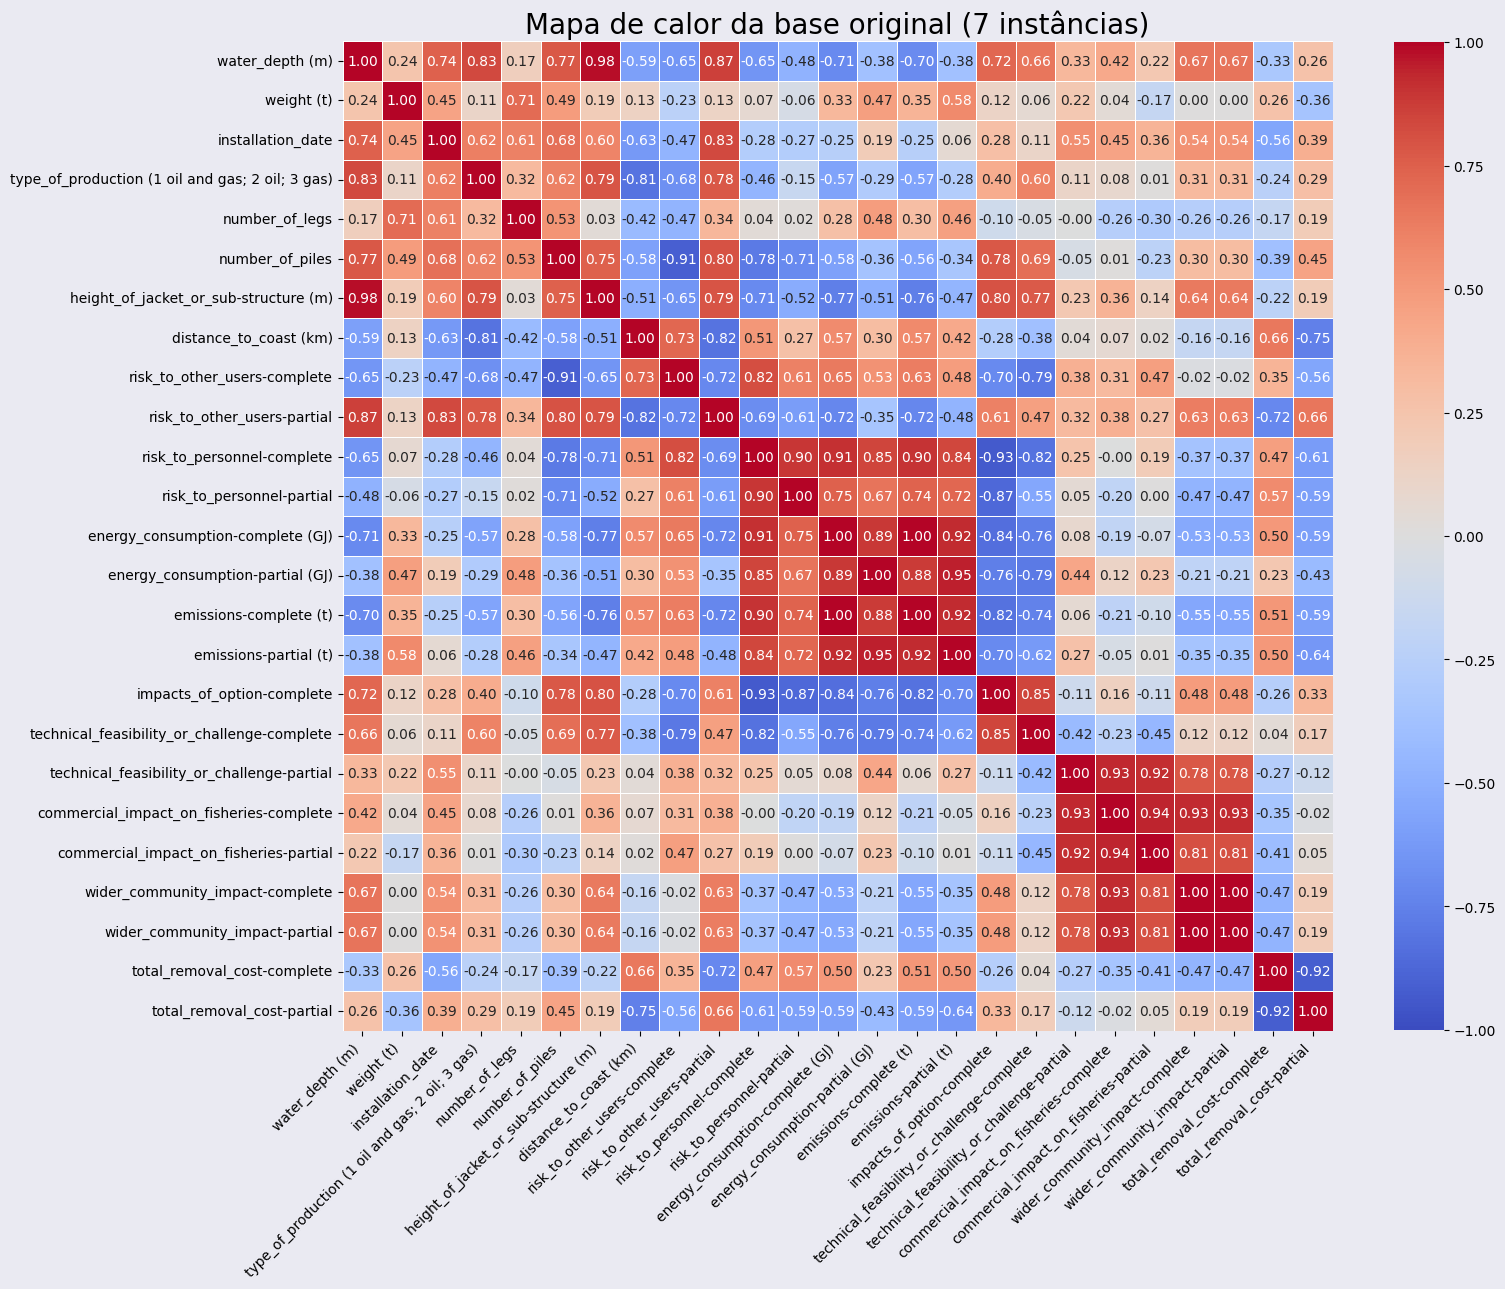

In [529]:
matriz_correlacao = df.corr()

# Plotando o gráfico
plt.figure(figsize=(16, 16), facecolor='#eaeaf2')

ax = sns.heatmap(data=matriz_correlacao,
                xticklabels=df.columns,
                yticklabels=df.columns,
                annot=True, 
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                fmt='.2f',
                linewidths=0.7,
                cbar=True,
                cbar_kws={"shrink": 0.685} 

)

# Ajustando as labels na linha x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# título e apresentação do gráfico
plt.title('Mapa de calor da base original (7 instâncias)', fontsize=20)

plt.tight_layout()

plt.show()

In [530]:
df_gan = pd.read_csv("../dados/registros_gan.csv")

In [531]:
df_gan.shape

(10000, 25)

In [532]:
df_gan.head()

,water_depth (m),weight (t),installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure (m),distance_to_coast (km),risk_to_other_users-complete,risk_to_other_users-partial,risk_to_personnel-complete,risk_to_personnel-partial,energy_consumption-complete (GJ),energy_consumption-partial (GJ),emissions-complete (t),emissions-partial (t),impacts_of_option-complete,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-complete,total_removal_cost-partial
0,150.062862,17381.097595,42.460773,1.838854,7.947612,20.076094,158.343701,194.479697,0.020759,1.575815e-05,0.092650,0.066884,441426.622169,545478.995634,32618.380575,37688.156673,0.719951,0.390254,0.982611,0.993360,0.904297,0.856872,0.916491,0.977601,0.608750
1,108.097451,17668.076764,37.888578,1.004137,7.867326,10.978940,126.001845,274.557733,0.996899,1.333454e-07,0.162256,0.093173,979886.735342,762796.649980,73655.505669,48009.706216,0.276892,0.017911,0.989987,0.958928,0.917987,0.695773,0.558075,0.992387,0.603635
2,123.426990,19954.615628,36.260089,1.632839,7.999963,22.574138,145.891663,161.267083,0.003304,1.663465e-07,0.217898,0.124142,828298.761300,616341.087566,53767.031989,51574.082705,0.126962,0.419219,0.355092,0.074630,0.109428,0.353967,0.291234,0.999917,0.578362
3,100.645458,13888.926813,31.519565,1.000203,4.229412,7.318522,120.058502,281.966368,0.999788,5.620718e-10,0.057672,0.045474,692480.780703,531998.683018,54563.323037,37119.328435,0.292899,0.136567,0.839196,0.890777,0.772148,0.413054,0.398592,0.999995,0.561459
4,148.481574,21662.174816,43.748371,2.648309,7.997297,25.389693,156.532241,138.077198,0.000115,1.984997e-05,0.093425,0.067380,462282.163026,588855.662970,36172.268481,45347.429204,0.508538,0.457769,0.873613,0.831653,0.550140,0.701047,0.768881,0.972611,0.624151


In [533]:
df

,water_depth (m),weight (t),installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure (m),distance_to_coast (km),risk_to_other_users-complete,risk_to_other_users-partial,risk_to_personnel-complete,risk_to_personnel-partial,energy_consumption-complete (GJ),energy_consumption-partial (GJ),emissions-complete (t),emissions-partial (t),impacts_of_option-complete,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-complete,total_removal_cost-partial
0,99,22000,36,1,8,8,114.0,269,1,0.000000e+00,0.290,0.12,1110100,817000,87000,58500,0.00,0.00,1.00,0.79,0.78,0.50,0.50,1.00,0.56
1,112,20364,41,1,8,9,123.0,259,1,0.000000e+00,0.320,0.16,1180500,895500,92000,64000,0.00,0.00,1.00,0.79,0.78,0.50,0.50,1.00,0.56
2,141,15561,46,2,8,26,147.0,120,0,2.300000e-05,0.025,0.01,297654,530148,24277,31064,0.66,0.25,1.00,1.00,0.94,1.00,1.00,0.53,1.00
3,156,27647,44,2,8,32,166.0,240,0,1.500000e-05,0.040,0.02,487750,570818,40416,45266,1.00,0.50,1.00,1.00,0.66,1.00,1.00,1.00,0.57
4,103,18584,33,1,8,20,122.5,230,0,7.800000e-08,0.090,0.06,733082,511765,59588,41170,0.53,0.39,0.15,0.00,0.00,0.00,0.00,1.00,0.73
5,144,17500,41,3,8,20,154.0,130,0,1.335933e-05,0.140,0.13,520000,568000,42000,44000,0.40,0.45,0.70,0.50,0.50,0.50,0.50,1.00,0.66
6,116,10054,31,1,4,5,136.0,282,1,0.000000e+00,0.140,0.08,469823,433179,37162,32191,0.53,0.29,0.81,0.93,0.86,0.83,0.83,1.00,0.60


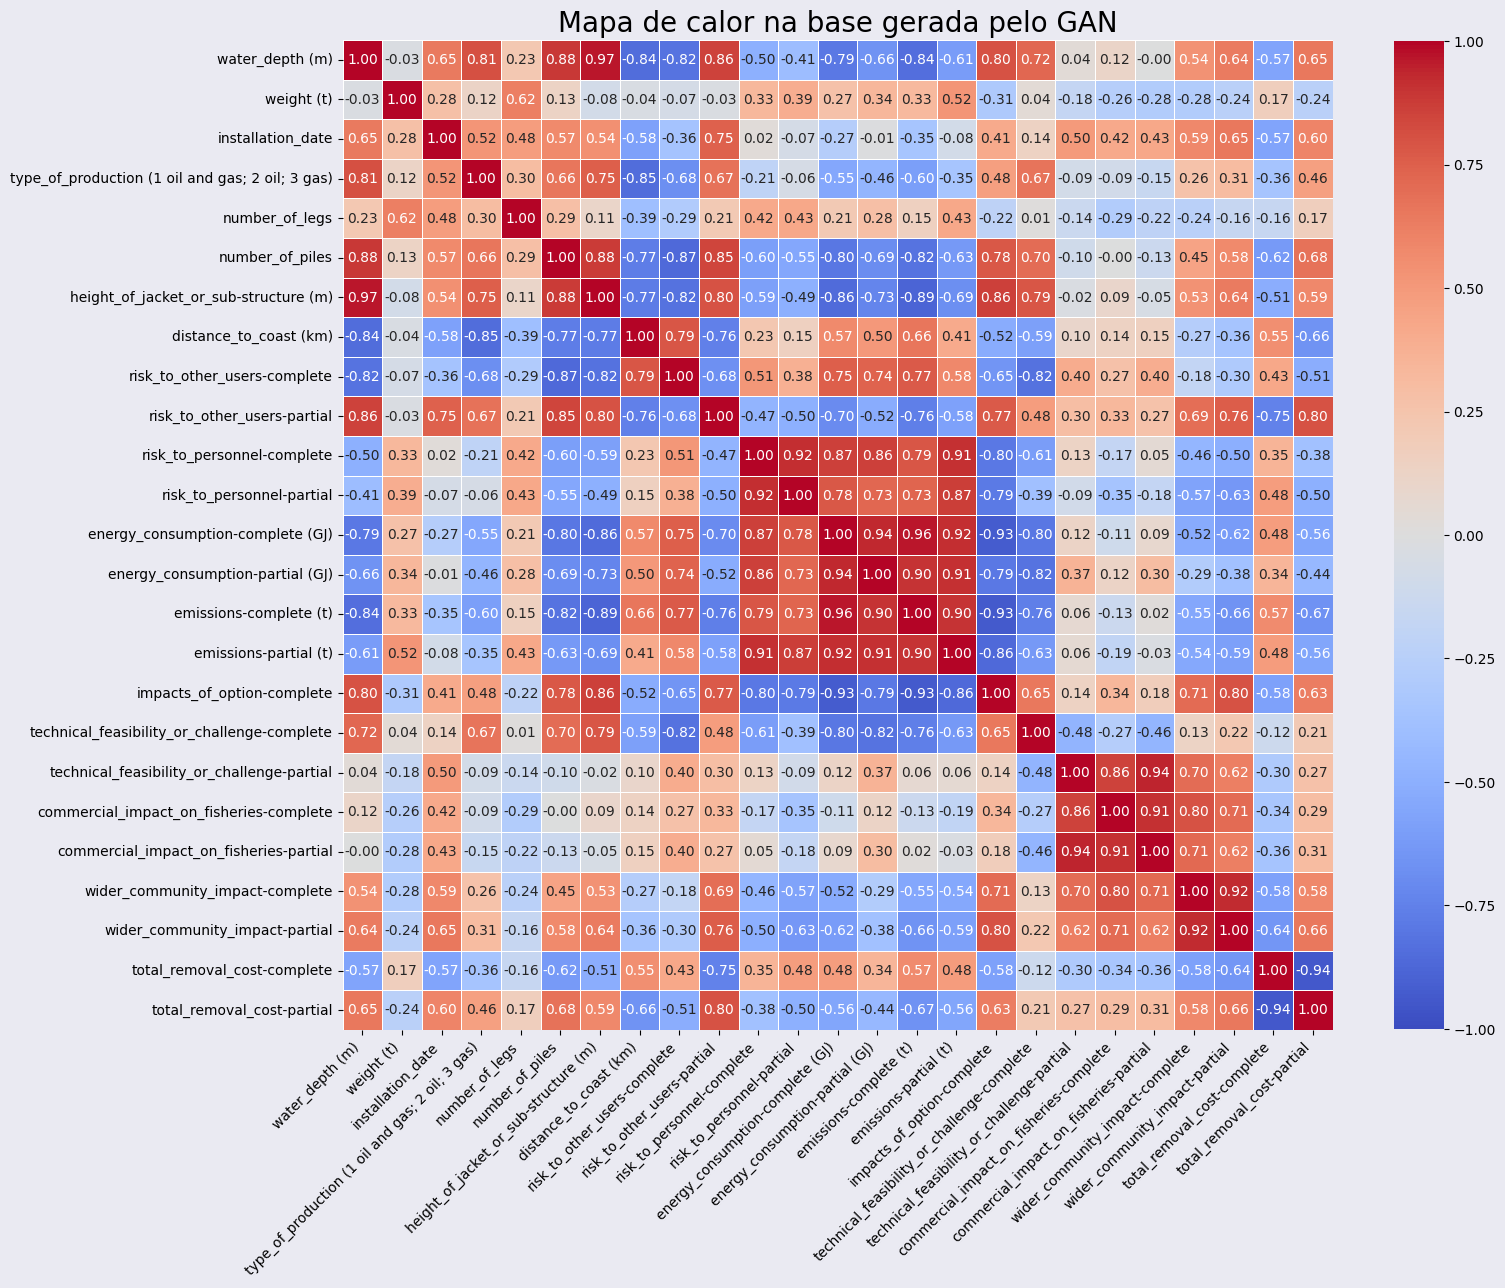

In [534]:
matriz_correlacao_gan = df_gan.corr()

# Plotando o gráfico
plt.figure(figsize=(16, 16), facecolor='#eaeaf2')

ax = sns.heatmap(data=matriz_correlacao_gan,
                xticklabels=df.columns,
                yticklabels=df.columns,
                annot=True, 
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True,
                fmt='.2f',
                linewidths=0.7,
                cbar=True,
                cbar_kws={"shrink": 0.685} 

)

# Ajustando as labels na linha x
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# título e apresentação do gráfico
plt.title('Mapa de calor na base gerada pelo GAN', fontsize=20)

plt.tight_layout()

plt.show()

#### formatando os resultados do novo dataframe

In [535]:
df_gan.head()

,water_depth (m),weight (t),installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure (m),distance_to_coast (km),risk_to_other_users-complete,risk_to_other_users-partial,risk_to_personnel-complete,risk_to_personnel-partial,energy_consumption-complete (GJ),energy_consumption-partial (GJ),emissions-complete (t),emissions-partial (t),impacts_of_option-complete,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-complete,total_removal_cost-partial
0,150.062862,17381.097595,42.460773,1.838854,7.947612,20.076094,158.343701,194.479697,0.020759,1.575815e-05,0.092650,0.066884,441426.622169,545478.995634,32618.380575,37688.156673,0.719951,0.390254,0.982611,0.993360,0.904297,0.856872,0.916491,0.977601,0.608750
1,108.097451,17668.076764,37.888578,1.004137,7.867326,10.978940,126.001845,274.557733,0.996899,1.333454e-07,0.162256,0.093173,979886.735342,762796.649980,73655.505669,48009.706216,0.276892,0.017911,0.989987,0.958928,0.917987,0.695773,0.558075,0.992387,0.603635
2,123.426990,19954.615628,36.260089,1.632839,7.999963,22.574138,145.891663,161.267083,0.003304,1.663465e-07,0.217898,0.124142,828298.761300,616341.087566,53767.031989,51574.082705,0.126962,0.419219,0.355092,0.074630,0.109428,0.353967,0.291234,0.999917,0.578362
3,100.645458,13888.926813,31.519565,1.000203,4.229412,7.318522,120.058502,281.966368,0.999788,5.620718e-10,0.057672,0.045474,692480.780703,531998.683018,54563.323037,37119.328435,0.292899,0.136567,0.839196,0.890777,0.772148,0.413054,0.398592,0.999995,0.561459
4,148.481574,21662.174816,43.748371,2.648309,7.997297,25.389693,156.532241,138.077198,0.000115,1.984997e-05,0.093425,0.067380,462282.163026,588855.662970,36172.268481,45347.429204,0.508538,0.457769,0.873613,0.831653,0.550140,0.701047,0.768881,0.972611,0.624151


##### Função para transformar os dados e padronizar conforme o original

In [536]:
def transforma_int(coluna):
    return int(coluna)

In [537]:
def transforma_float(column):
    return round(float(column), 3)

In [538]:
def mapear_0_ou_1(valor):
    if valor <= 0.5:
        return 0
    else:
        return 1

In [539]:
def mapear_type_of_production(valor):
    if valor <= 1.5:
        return 1
    elif valor <= 2.5:
        return 2
    else:
        return 3

##### Separando as colunas para os tipos de transformação

In [540]:
df_gan.columns

Index(['water_depth (m)', 'weight (t)', 'installation_date',
       'type_of_production (1 oil and gas; 2 oil; 3 gas)', 'number_of_legs',
       'number_of_piles', 'height_of_jacket_or_sub-structure (m)',
       'distance_to_coast (km)', 'risk_to_other_users-complete',
       'risk_to_other_users-partial', 'risk_to_personnel-complete',
       'risk_to_personnel-partial', 'energy_consumption-complete (GJ)',
       'energy_consumption-partial (GJ)', 'emissions-complete (t)',
       'emissions-partial (t)', 'impacts_of_option-complete',
       'technical_feasibility_or_challenge-complete',
       'technical_feasibility_or_challenge-partial',
       'commercial_impact_on_fisheries-complete',
       'commercial_impact_on_fisheries-partial',
       'wider_community_impact-complete', 'wider_community_impact-partial',
       'total_removal_cost-complete', 'total_removal_cost-partial'],
      dtype='object')

In [541]:
colunas_float = ['height_of_jacket_or_sub-structure (m)', 'height_of_jacket_or_sub-structure (m)', 'risk_to_personnel-complete', 'risk_to_personnel-partial', 'technical_feasibility_or_challenge-complete', 'technical_feasibility_or_challenge-partial', 'commercial_impact_on_fisheries-complete', 'commercial_impact_on_fisheries-partial', 'wider_community_impact-complete', 'wider_community_impact-partial', 'total_removal_cost-complete', 'total_removal_cost-partial', 'impacts_of_option-complete']
colunas_int = ['water_depth (m)', 'installation_date', 'weight (t)', 'number_of_legs', 'number_of_piles', 'distance_to_coast (km)', 'energy_consumption-complete (GJ)', 'energy_consumption-partial (GJ)', 'emissions-complete (t)', 'emissions-partial (t)']

**OBS:** A coluna `risk_to_other_users-partial` contém diferentes tamanhos de valores float, como 2.3 x 10<sup>-5</sup> ou 7.8 x 10<sup>-8</sup>. Portanto, não será formatada conforme as demais.

##### Aplicando as transformações

In [542]:
# Aplicando as transformações às colunas específicas
df_gan['risk_to_other_users-complete'] = df_gan['risk_to_other_users-complete'].apply(mapear_0_ou_1)
df_gan['type_of_production (1 oil and gas; 2 oil; 3 gas)'] = df_gan['type_of_production (1 oil and gas; 2 oil; 3 gas)'].apply(mapear_type_of_production)

# Aplicando outras transformações
for coluna in colunas_float:
    df_gan[coluna] = df_gan[coluna].apply(transforma_float)

for coluna in colunas_int:
    df_gan[coluna] = df_gan[coluna].apply(transforma_int)


In [543]:
# Configurações para exibição do DataFrame
pd.set_option('display.max_columns', None)  # Mostrar todas as colunas
pd.set_option('display.max_rows', None)     # Mostrar todas as linhas
pd.set_option('display.max_colwidth', None) # Mostrar todo o conteúdo das células


df_gan.head(10)

,water_depth (m),weight (t),installation_date,type_of_production (1 oil and gas; 2 oil; 3 gas),number_of_legs,number_of_piles,height_of_jacket_or_sub-structure (m),distance_to_coast (km),risk_to_other_users-complete,risk_to_other_users-partial,risk_to_personnel-complete,risk_to_personnel-partial,energy_consumption-complete (GJ),energy_consumption-partial (GJ),emissions-complete (t),emissions-partial (t),impacts_of_option-complete,technical_feasibility_or_challenge-complete,technical_feasibility_or_challenge-partial,commercial_impact_on_fisheries-complete,commercial_impact_on_fisheries-partial,wider_community_impact-complete,wider_community_impact-partial,total_removal_cost-complete,total_removal_cost-partial
0,150,17381,42,2,7,20,158.344,194,0,1.575815e-05,0.093,0.067,441426,545478,32618,37688,0.720,0.390,0.983,0.993,0.904,0.857,0.916,0.978,0.609
1,108,17668,37,1,7,10,126.002,274,1,1.333454e-07,0.162,0.093,979886,762796,73655,48009,0.277,0.018,0.990,0.959,0.918,0.696,0.558,0.992,0.604
2,123,19954,36,2,7,22,145.892,161,0,1.663465e-07,0.218,0.124,828298,616341,53767,51574,0.127,0.419,0.355,0.075,0.109,0.354,0.291,1.000,0.578
3,100,13888,31,1,4,7,120.059,281,1,5.620718e-10,0.058,0.045,692480,531998,54563,37119,0.293,0.137,0.839,0.891,0.772,0.413,0.399,1.000,0.561
4,148,21662,43,3,7,25,156.532,138,0,1.984997e-05,0.093,0.067,462282,588855,36172,45347,0.509,0.458,0.874,0.832,0.550,0.701,0.769,0.973,0.624
5,138,22076,40,2,7,23,139.909,129,0,7.091739e-06,0.049,0.061,365601,457295,42822,37949,0.354,0.496,0.380,0.202,0.067,0.377,0.357,1.000,0.607
6,134,20737,40,1,7,24,149.745,258,0,1.290168e-05,0.030,0.015,330738,482090,35206,35644,0.614,0.433,0.842,0.978,0.571,0.705,0.851,0.995,0.586
7,107,20651,32,1,7,12,126.808,230,0,3.840595e-09,0.196,0.145,755781,615229,73760,53266,0.061,0.406,0.218,0.041,0.026,0.163,0.218,1.000,0.564
8,99,23559,43,1,7,6,114.333,281,1,6.854534e-13,0.318,0.156,1178227,894785,91909,63873,0.001,0.000,1.000,0.978,0.936,0.603,0.553,1.000,0.560
9,99,12393,31,1,4,5,115.691,281,1,6.100535e-11,0.066,0.051,834828,622052,70833,35137,0.153,0.017,0.998,0.993,0.936,0.704,0.421,1.000,0.561


#### Salvando resultados

In [544]:
df_gan.to_csv('../dados/registros_gan.csv', index=False)